In [1]:
from altaipony.lcio import from_TargetPixel_source
import numpy as np
import matplotlib.pyplot as plt

Loading KWallet
Loading SecretService
Loading Windows
Loading chainer
Loading macOS
/usr/lib/python3.6/importlib/_bootstrap.py:371: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1000/bus>
  self.name = name
/usr/lib/python3.6/importlib/_bootstrap.py:371: ResourceWarning: unclosed <socket.socket fd=59, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1000/bus>
  self.name = name
/usr/lib/python3.6/importlib/_bootstrap.py:371: ResourceWarning: unclosed <socket.socket fd=60, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1000/bus>
  self.name = name
/usr/lib/python3.6/importlib/_bootstrap.py:371: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1000/bus>
  self.name = name
/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/l

Find and download the TargetPixelFile for your light curve:

In [2]:
flc = from_TargetPixel_source("10002792", quarter=2)

Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/Kepler/kplr010002792_lc_Q011111111111111111/kplr010002792-2009259160929_lpd-targ.fits.gz with expected size 2258267.
6% (279/4354) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
6% (279/4354) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


Find the gaps in the light curve to inform the de-trending algorithm. 

The de-trending splits the light curve in continuous chunks to avoid flukes from over-fitting.

In [3]:
flc = flc.find_gaps()
splits = [j for (i,j) in flc.gaps]
splits

[570, 2495, 2807, 3967, 4070]

De-trend the light curve using K2SC, save the result in a .fits file. Do not forget to pass the splits. 

The flare finding is sensitive to the `outlier_sigma` parameter that clips the the flare candidates while modeling the non-flaring light curve. There is a small bug in K2SC: `outlier_sigma` is not passed on (see [Github issue](https://github.com/OxES/k2sc/issues/20)). You will have to manually fix this is your local version of K2SC (not the best solution, but a working one). Or you cann install K2SC from my [fork](https://github.com/ekaterinailin/k2sc) of it.

If you want to check if it worked: Different `outlier_sigma` should give different numbers in the de-trending protocol that you see when you run the cell below:

    Flagged X ( X.X%) outliers.)
    

In [4]:
flcd = flc.detrend(save_k2sc=True, folder='', de_niter=10, splits=splits, outlier_sigma=3)

Using split values [570, 2495, 2807, 3967, 4070] given from the command line
Starting initial outlier detection
  Flagged 3 ( 0.1%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    1.16 (fap 0.0000e+00 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -4192.901413733671
  DE iteration %3i -ln(L) %4.1f 1 -4192.901413733671
  DE iteration %3i -ln(L) %4.1f 2 -4192.901413733671
  DE iteration %3i -ln(L) %4.1f 3 -4192.901413733671
  DE iteration %3i -ln(L) %4.1f 4 -4192.901413733671
  DE iteration %3i -ln(L) %4.1f 5 -4192.901413733671
  DE iteration %3i -ln(L) %4.1f 6 -4192.901413733671
  DE iteration %3i -ln(L) %4.1f 7 -4192.901413733671
  DE iteration %3i -ln(L) %4.1f 8 -4192.901413733671
  DE iteration %3i -ln(L) %4.1f 9 -4192.901413733671
  DE finished in %i seconds 55.06026887893677
  DE minimum found at: %s [-4.493  0.115  1.162  0.31  -3.471 18.03  13.

De-trending successfully completed.
Value for campaign is None.
Value for campaign is None.


  CDPP - raw - %6.3f 6863.666116933351
  CDPP - position component removed - %6.3f 6839.556694345599
  CDPP - full reduction - %6.3f 244.48143328705646
Detrending time %6.3f 84.5916690826416


Now you can visually compare the results:

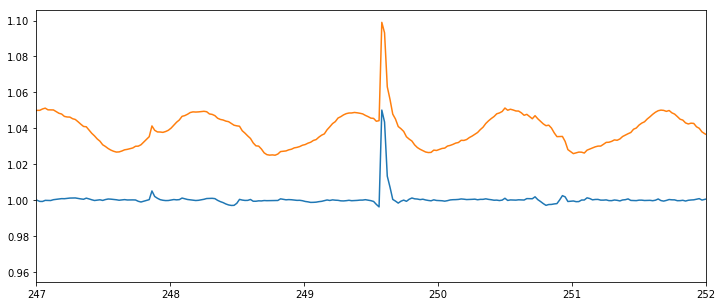

In [5]:
plt.figure(figsize=(12,5))
plt.plot(flcd.time,flcd.detrended_flux / np.nanmedian(flcd.detrended_flux))
plt.plot(flcd.time, flcd.flux / np.nanmedian(flcd.flux))
plt.xlim(247,252);

The above figure shows a flare that we can now try to find in the de-trended light curve:

In [6]:
flcd = flcd.find_flares()
flcd.flares

Found 0 candidate(s) in the (0,570) gap.
Found 2 candidate(s) in the (570,2495) gap.
Found 0 candidate(s) in the (2495,2807) gap.
Found 1 candidate(s) in the (2807,3967) gap.
Found 0 candidate(s) in the (3967,4070) gap.
/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,tstart,tstop
0,0.009332,4216,4219,36.657621,0.247029,1121,1124,195.082817,195.144118
1,0.023509,4716,4719,68.386212,0.231110,1615,1618,205.299677,205.360978
2,0.050181,6883,6887,201.821672,0.264874,3684,3688,249.578843,249.660576


It should one of the largest flares.

Questions? Something does not work? Email me @ eilin@aip.de 